# Set Up

## Configs

In [2]:
n_terms = 5000
n_topics = 30
max_iter = 5

## Imports

In [3]:
import pandas as pd
import numpy as np
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk import sent_tokenize
from nltk import word_tokenize
import nltk

In [4]:
%matplotlib inline

In [5]:
news = pd.read_csv('ETA-master/newzy.csv',sep = '|')

In [6]:
data = news[news.doc_source.isin(['PowerLine', 'Daily Kos'])].reset_index(drop = True)

In [7]:
# remove the author name from the doc_content 
doc_content = []
for i in data.doc_content:
    if str(i)[0]=="(":
        doc_content.append(str(i)[str(i).find(")")+1:])
    else: doc_content.append(str(i))
data.doc_content = doc_content

In [8]:
# get the day number from date
j = []
for i in data.doc_date:
    if i[-7:-6] =='0':
        j.append(int(i[-6]))
    else: 
        j.append(int(i[-7:-5]))

In [9]:
data['year'] = data.doc_date.apply(lambda x: int(x[-4:])) # get year from date  
data['month'] = data.doc_date.apply(lambda x: int(x[:2])) # get month from date
data['date'] = j

In [11]:
#get week from doc_date 
week = []
for i in range(len(data)):
    week.append(datetime.date(data.iloc[i]['year'], data.iloc[i]['month'], data.iloc[i]['date']).strftime("%V"))
data['week'] = week

In [12]:
data.head()

doc_id doc_source                                          doc_title  \
0      48  PowerLine                              These Zins Are a Dusi   
1      49  PowerLine       NY Times Editorial Board Hacked by The Onion   
2      50  PowerLine                             The line Obama crossed   
3      51  PowerLine                                           Sham/Wow   
4      52  PowerLine  A Quarterback Controversy With a Political Twist?   

                                         doc_content    doc_date  \
0   I’ve been falling behind on many regular feat...  11/03/2013   
1   At least I think it was the Onion. Someone, a...  11/03/2013   
2   Obamacare was enacted on a foundational set o...  11/03/2013   
3   It’s unfair to compare and contrast Barack Ob...  11/03/2013   
4   Public Policy Polling ran a survey here in Mi...  11/03/2013   

                                             doc_url  year  month  date week  
0  http://feeds.powerlineblog.com/~r/powerlineblo...  2013     11     3   44  
1  http://feeds.powerlineblog.com/~r/powerlineblo...  2013     11     3   44  
2  http://feeds.powerlineblog.com/~r/powerlineblo...  2013     11     3   44  
3  http://feeds.powerlineblog.com/~r/powerlineblo...  2013     11     3   44  
4  http://feeds.powerlineblog.com/~r/powerlineblo...  2013     11     3   44

In [35]:
LIB = data[['doc_id', 'doc_source', 'doc_title', 'doc_date']].set_index('doc_id')
#LIBRARY = LIBRARY.reset_index().set_index(OHCO[:2]).drop(columns = 'index')
LIB.head() 

doc_source                                          doc_title  \
doc_id                                                                 
48      PowerLine                              These Zins Are a Dusi   
49      PowerLine       NY Times Editorial Board Hacked by The Onion   
50      PowerLine                             The line Obama crossed   
51      PowerLine                                           Sham/Wow   
52      PowerLine  A Quarterback Controversy With a Political Twist?   

          doc_date  
doc_id              
48      11/03/2013  
49      11/03/2013  
50      11/03/2013  
51      11/03/2013  
52      11/03/2013

In [13]:
DOC = data[['doc_date','doc_id','doc_source','doc_title','doc_content','doc_url']].set_index(['doc_id','doc_date'])
DOC.head()

doc_source  \
doc_date   doc_id              
11/03/2013 48      PowerLine   
           49      PowerLine   
           50      PowerLine   
           51      PowerLine   
           52      PowerLine   

                                                           doc_title  \
doc_date   doc_id                                                      
11/03/2013 48                                  These Zins Are a Dusi   
           49           NY Times Editorial Board Hacked by The Onion   
           50                                 The line Obama crossed   
           51                                               Sham/Wow   
           52      A Quarterback Controversy With a Political Twist?   

                                                         doc_content  \
doc_date   doc_id                                                      
11/03/2013 48       I’ve been falling behind on many regular feat...   
           49       At least I think it was the Onion. Someone, a...   
           50       Obamacare was enacted on a foundational set o...   
           51       It’s unfair to compare and contrast Barack Ob...   
           52       Public Policy Polling ran a survey here in Mi...   

                                                             doc_url  
doc_date   doc_id                                                     
11/03/2013 48      http://feeds.powerlineblog.com/~r/powerlineblo...  
           49      http://feeds.powerlineblog.com/~r/powerlineblo...  
           50      http://feeds.powerlineblog.com/~r/powerlineblo...  
           51      http://feeds.powerlineblog.com/~r/powerlineblo...  
           52      http://feeds.powerlineblog.com/~r/powerlineblo...

# Prepare Data

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [15]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(DOC.doc_content)
TERMS = tfv.get_feature_names()

# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [16]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [17]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=DOC.index)
THETA.columns.name = 'topic_id'

In [18]:
THETA.sample(20).style.background_gradient()

## PHI

In [19]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [20]:
PHI.T.head().style.background_gradient()

# Inspect Results

## Get Top Terms per Topic

In [21]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [22]:
TOPICS

term_str            0           1              2              3           4  \
topic_id                                                                      
0             clinton     hillary           news          email         fox   
1               trump       white          party      democrats       house   
2               trump       comey  investigation      president      russia   
3                left   political   conservative          right     liberal   
4               trump      russia          obama        russian       putin   
5              senate       house    republicans     republican        vote   
6               state   democrats       election     democratic  republican   
7         immigration  immigrants      immigrant    enforcement         law   
8                time        like           just           book         new   
9               trump         war          syria           isis        iraq   
10              court      senate          trump      democrats   president   
11             health        care         people            tax   insurance   
12            climate      energy         change          power        coal   
13                 00     percent           2017            gun          pm   
14                com    function        ellison            www        http   
15               iran       order            ban          judge     iranian   
16                fbi       trump    information  investigation  department   
17              women      police          black           said       white   
18              trump    campaign           live         senate      donald   
19              trump   president        nuclear          north        deal   
20           students      school        college     university   education   
21              state       court            law        federal      rights   
22          kavanaugh        game           team          judge        time   
23              trump     percent           jobs            new   president   
24              trump   president          think         people         don   
25              trump      donald          white          house   president   
26         california       state           wage         harris       brown   
27             warren       biden        sanders     democratic         new   
28               omar   minnesota          story           star     tribune   
29              trump     youtube       sessions        patreon      listen   

term_str              5               6            7               8  \
topic_id                                                               
0                 kelly           house        trump           obama   
1                  anti       president        media      democratic   
2                donald        campaign      russian           flynn   
3                social         science      climate          change   
4             president  administration      foreign        election   
5                  said       mcconnell         ryan          repeal   
6                 trump     republicans          gop        district   
7                   ice            said      federal    undocumented   
8                people           years          day           great   
9              military          attack       forces       president   
10              supreme         justice  republicans       mcconnell   
11          republicans       obamacare         plan        medicaid   
12               global           years          new             gas   
13            wednesday          people        moore            poll   
14        powerlineblog            file       jquery        jwplayer   
15               muslim          states        court      government   
16         intelligence          report        story         mueller   
17               people             men        woman          sexual   
18                   ad        

In [23]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

## Sort Topics by Doc Weight

In [24]:
TOPICS['doc_weight_sum'] = THETA.sum()

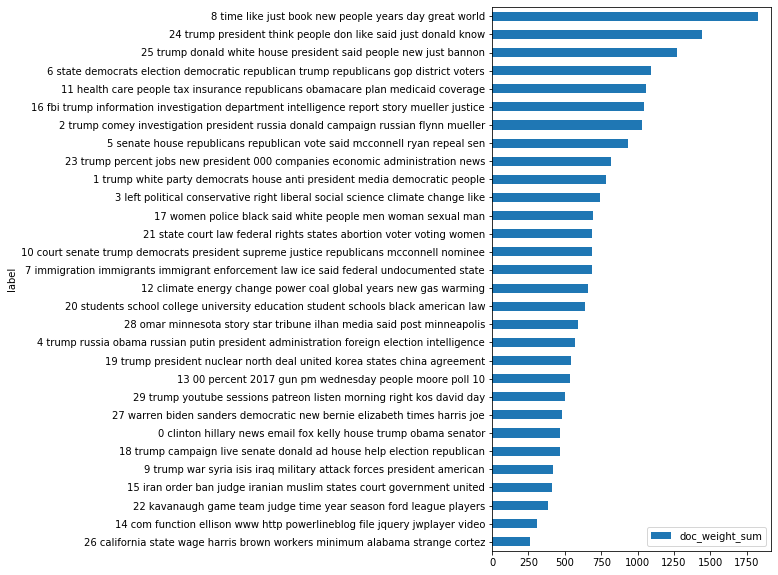

In [25]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

## Explore Topics by Author

In [41]:
THETA

topic_id                  0         1         2         3         4   \
doc_date   doc_id                                                      
11/03/2013 48       0.000251  0.000251  0.000251  0.000251  0.000251   
           49       0.000222  0.000222  0.000222  0.000222  0.105094   
           50       0.000340  0.000340  0.000340  0.000340  0.103265   
           51       0.202197  0.000794  0.000794  0.000794  0.194138   
           52       0.000139  0.240672  0.000139  0.032831  0.000139   
...                      ...       ...       ...       ...       ...   
02/27/2020 1026329  0.000175  0.134251  0.000175  0.416313  0.000175   
           1026330  0.000119  0.000119  0.000119  0.000119  0.000119   
           1026331  0.000265  0.000265  0.000265  0.000265  0.000265   
           1026332  0.000355  0.000355  0.000355  0.000355  0.000355   
           1026333  0.000188  0.000188  0.000188  0.000188  0.000188   

topic_id                  5         6         7         8         9   ...  \
doc_date   doc_id                                                     ...   
11/03/2013 48       0.000251  0.000251  0.000251  0.062906  0.000251  ...   
           49       0.000222  0.000222  0.000222  0.000222  0.000222  ...   
           50       0.000340  0.000340  0.000340  0.248595  0.000340  ...   
           51       0.000794  0.000794  0.000794  0.000794  0.000794  ...   
           52       0.000139  0.049575  0.000139  0.000139  0.000139  ...   
...                      ...       ...       ...       ...       ...  ...   
02/27/2020 1026329  0.000175  0.000175  0.000175  0.000175  0.000175  ...   
           1026330  0.000119  0.000119  0.000119  0.000119  0.000119  ...   
           1026331  0.000265  0.000265  0.000265  0.000265  0.000265  ...   
           1026332  0.000355  0.000355  0.336609  0.000355  0.000355  ...   
           1026333  0.000188  0.000188  0.000188  0.000188  0.000188  ...   

topic_id                  20        21        22        23        24  \
doc_date   doc_id                                                      
11/03/2013 48       0.000251  0.000251  0.000251  0.000251  0.000251   
           49       0.000222  0.000222  0.000222  0.074311  0.000222   
           50       0.000340  0.000340  0.000340  0.000340  0.000340   
           51       0.000794  0.000794  0.000794  0.318843  0.000794   
           52       0.000139  0.000139  0.330400  0.000139  0.095005   
...                      ...       ...       ...       ...       ...   
02/27/2020 1026329  0.000175  0.000175  0.000175  0.000175  0.178980   
           1026330  0.810318  0.042279  0.000119  0.000119  0.000119   
           1026331  0.000265  0.000265  0.000265  0.301549  0.662212   
           1026332  0.000355  0.374192  0.000355  0.000355  0.000355   
           1026333  0.142500  0.000188  0.000188  0.000188  0.314382   

topic_id                  25        26        27        28        29  
doc_date   doc_id                                                     
11/03/2013 48       0.000251  0.000251  0.000251  0.000251  0.000251  
           49       0.000222  0.000222  0.000222  0.000222  0.000222  
           50       0.000340  0.000340  0.000340  0.186054  0.000340  
           51       0.000794  0.000794  0.000794  0.000794  0.000794  
           52       0.000139  0.000139  0.000139  0.231875  0.000139  
...                      ...       ...       ...       ...       ...  
02/27/2020 1026329  0.000175  0.000175  0.265895  0.000175  0.000175  
           1026330  0.000119  0.000119  0.000119  0.000119  0.000119  
           1026331  0.000265  0.000265  0.000265  0.000265  0.000265  
           1026332  0.000355  0.000355  0.000355  0.000355  0.000355  
           1026333  0.174872  0.027422  0.000188  0.150829  0.000188  

[22040 rows x 30 columns]

In [50]:
LIB[['doc_source','doc_title']]

doc_source                                          doc_title
doc_id                                                               
48       PowerLine                              These Zins Are a Dusi
49       PowerLine       NY Times Editorial Board Hacked by The Onion
50       PowerLine                             The line Obama crossed
51       PowerLine                                           Sham/Wow
52       PowerLine  A Quarterback Controversy With a Political Twist?
...            ...                                                ...
1026329  PowerLine  The Democrats’ Bernie Dilemma: He Exposes Thei...
1026330  PowerLine  Trump DOJ weighs in against Harvard’s discrimi...
1026331  PowerLine                     Trump Steps Out on Coronavirus
1026332  PowerLine          A Legal Blow to “Sanctuary” Jurisdictions
1026333  PowerLine                 Omar Slanders a Much Better Person

[22040 rows x 2 columns]

In [58]:
SOURCE =  THETA.join(LIB[['doc_source','doc_title']], on='doc_id')\
    .reset_index().set_index(['doc_source'])\
    .groupby('doc_source')[topic_cols].mean()\
    .T
SOURCE.index.name = 'topic_id'

In [59]:
SOURCE['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [61]:
SOURCE.sort_values('PowerLine', ascending=False).style.background_gradient()

In [62]:
SOURCE.sort_values('Daily Kos', ascending=False).style.background_gradient()

In [63]:
import plotly_express as px

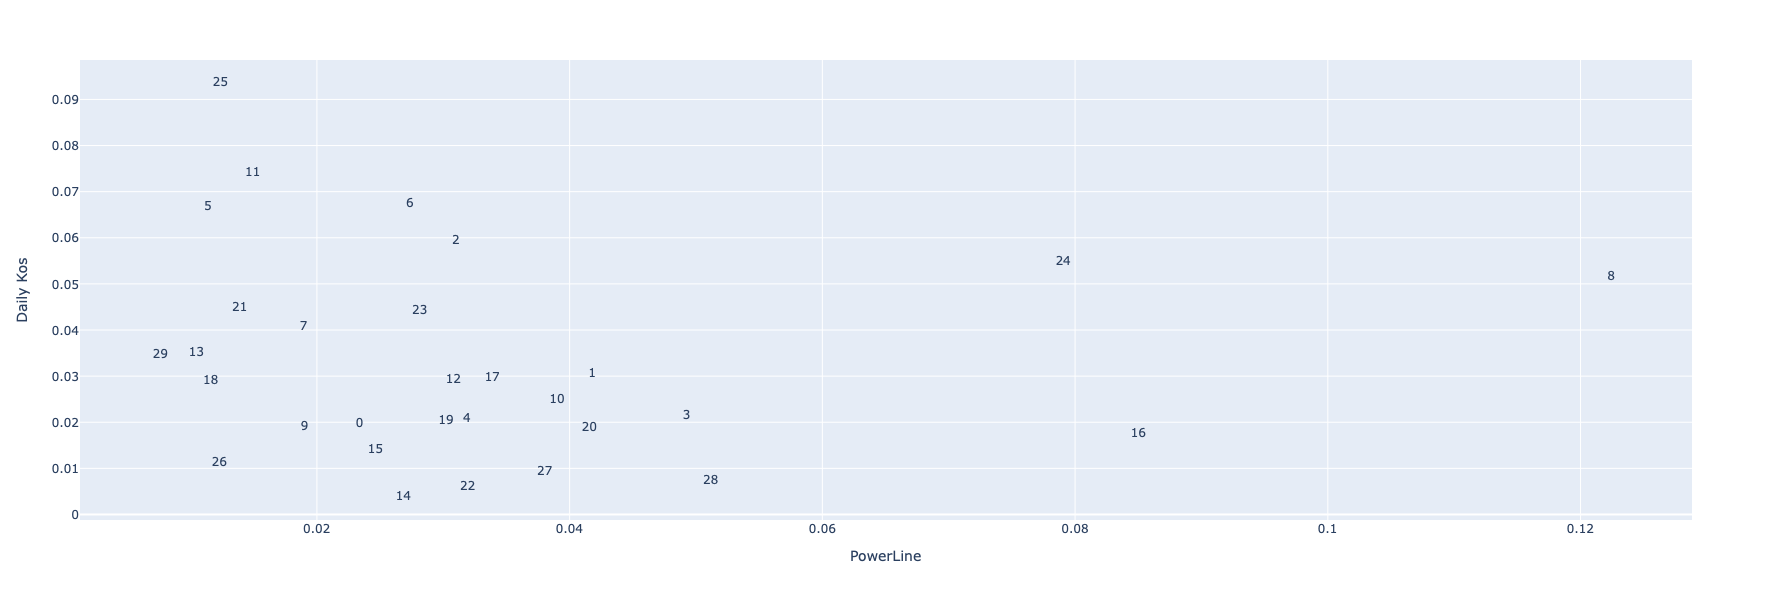

In [64]:
px.scatter(SOURCE.reset_index(), 'PowerLine', 'Daily Kos', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

# Clutser Topics

In [65]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [66]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [67]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [68]:
labels  = ["{}: {}".format(a,b) for a, b in zip(SOURCE.index,  SOURCE.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

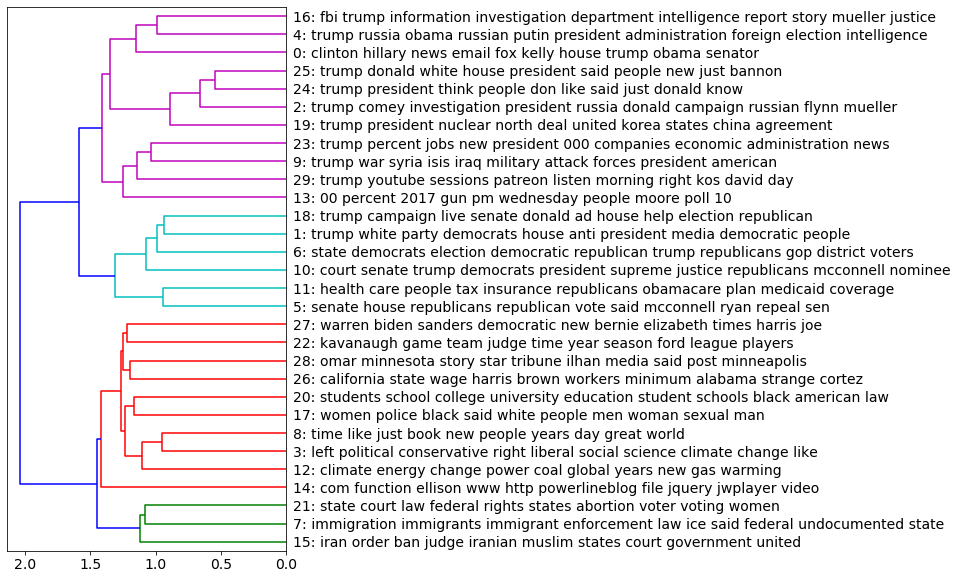

In [69]:
plot_tree(TREE, labels)

# LDA Viz

In [70]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [71]:
pyLDAvis.sklearn.prepare(lda, tf, tfv)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.047552 -0.025168       1        1  8.116080
24    -0.045450  0.042698       2        1  6.117193
16    -0.102721 -0.057315       3        1  5.679023
6      0.085092  0.145788       4        1  4.886205
11     0.162256  0.047974       5        1  4.718554
25     0.014068  0.021698       6        1  4.670203
2     -0.082574  0.052121       7        1  4.401598
23     0.072317 -0.046415       8        1  4.019531
3      0.011798 -0.024906       9        1  3.852901
5      0.091680  0.134643      10        1  3.654915
20     0.025647 -0.114886      11        1  3.452163
10     0.043227  0.067785      12        1  3.344908
12     0.085440 -0.082107      13        1  3.299185
21     0.155083 -0.039312      14        1  3.249727
7      0.072967 -0.142963      15        1  3.109941
17    -0.069260 -0.065481      16        1  3.084703
1     -0.037276  0.061805      17        1  3.066201
28    -0.103061 -0.068428      18        1  3.007397
4     -0.067901 -0.032662      19        1  2.911127
19     0.030196 -0.059350      20        1  2.611890
29    -0.022094  0.074507      21        1  2.336340
9      0.002709 -0.073778      22        1  2.190505
22    -0.066770 -0.007799      23        1  2.169407
15     0.043792 -0.146271      24        1  2.017688
13     0.062308  0.042352      25        1  2.007593
0     -0.090759  0.064528      26        1  1.925023
27    -0.044462  0.062255      27        1  1.908915
18    -0.009121  0.148942      28        1  1.684665
14    -0.197789  0.007343      29        1  1.406534
26     0.028211  0.012402      30        1  1.099885, topic_info=     Category          Freq     Term         Total  loglift  logprob
4665  Default  57872.000000    trump  57872.000000  30.0000  30.0000
872   Default   6973.000000  clinton   6973.000000  29.0000  29.0000
4072  Default   8331.000000   senate   8331.000000  28.0000  28.0000
1118  Default   6210.000000    court   6210.000000  27.0000  27.0000
3970  Default   5154.000000   russia   5154.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
2511  Topic30    167.668316     just  15137.812453   0.0070  -5.4498
4354  Topic30    142.847920    story   6232.933697   0.7341  -5.6100
848   Topic30    132.510724     city   2599.027176   1.5337  -5.6851
4588  Topic30    145.095154     time  12412.835967   0.0609  -5.5943
3042  Topic30    140.874229      new  14810.260987  -0.1452  -5.6239

[1743 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.005758       00
0         3  0.000720       00
0         7  0.000720       00
0         9  0.000360       00
0        10  0.007558       00
...     ...       ...      ...
4995     23  0.000652  youtube
4995     24  0.001304  youtube
4995     25  0.001956  youtube
4995     28  0.028032  youtube
4995     29  0.021513  youtube

[20702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 25, 17, 7, 12, 26, 3, 24, 4, 6, 21, 11, 13, 22, 8, 18, 2, 29, 5, 20, 30, 10, 23, 16, 14, 1, 28, 19, 15, 27])